## 2. Preprocessing
For each model:
- Removing data (missing data, zero values, tails) ! duplicate?
- Transforming target https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html
- Transforming features https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler

### Setup

In [1]:
import pandas as pd
import numpy as np

from scipy import stats 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### m1

In [14]:
df_m1 = pd.read_csv('data/split/train.csv', parse_dates=['release'])

# m1 = popularity
df_m1 = df_m1.drop(columns=['release'])

#### Missing data

In [15]:
n_orig = df_m1.shape[0]

# Drop na values
n_na = df_m1['popularity'].isna().sum()
df_m1 = df_m1.dropna(subset=['popularity'])

# Drop zero values
n_zero =df_m1.loc[df_m1['popularity']==0].shape[0]
df_m1 = df_m1.loc[df_m1['popularity']>0]

print(f'm1: Dropped {n_na} na entries and {n_zero} zero entries of {n_orig}, {df_m1.shape[0]} entries left.')

m1: Dropped 0 na entries and 1 zero entries of 85259, 85258 entries left.


#### Target transformation

In [4]:
y1 = df_m1['popularity']

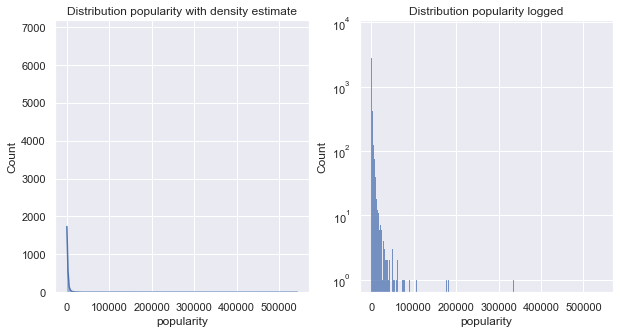

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(x=y1, kde=True, ax=axs[0])
ax1.set(title="Distribution popularity with density estimate")

ax2 = sns.histplot(x=y1, log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution popularity logged")

fig;

In [6]:
y1 = stats.boxcox(y1)[0]

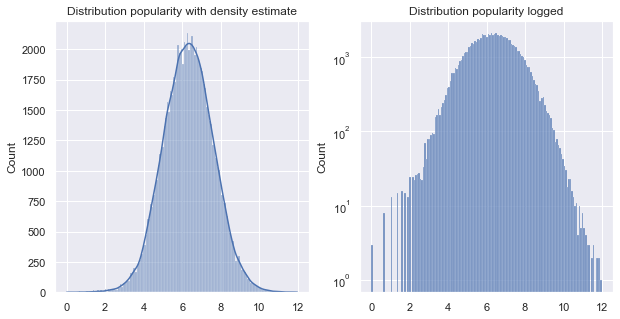

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(x=y1, kde=True, ax=axs[0])
ax1.set(title="Distribution popularity with density estimate")

ax2 = sns.histplot(x=y1, log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution popularity logged")

fig;

In [12]:
np.savetxt('featsets/m1/y.csv', y1, delimiter=",")

#### Feature transformation

In [16]:
X1 = df_m1.drop(columns=['popularity'])

X1 = StandardScaler().fit_transform(X1)
# X1 = RobustScaler().fit_transform(X1)

np.savetxt('featsets/m1/X.csv', X1, delimiter=",")

### m2

In [11]:
df_m2 = pd.read_csv('data/split/train.csv', parse_dates=['release'])

# m2 = release
df_m2 = df_m2.drop(columns=['popularity'])

#### Removing data

In [12]:
n_orig = df_m2.shape[0]

# Drop na values
n_na = df_m2['release'].isna().sum()
df_m2 = df_m2.dropna(subset=['release'])

# Change dtype: bin per year
df_m2['release'] = df_m2['release'].dt.year.astype(int)

# Drop years <1980
n_under = df_m2.loc[df_m2['release']<1980].shape[0]
df_m2 = df_m2.loc[df_m2['release']>=1980]

# Drop years >2017
n_above = df_m2.loc[df_m2['release']>2017].shape[0]
df_m2 = df_m2.loc[df_m2['release']<=2017]

print(f'm2: Dropped {n_na} na values, {n_under} values < 980 and {n_above} values >2017 of {n_orig}, {df_m2.shape[0]} entries left.')

m2: Dropped 28915 na values, 69 values < 980 and 2 values >2017 of 85259, 56273 entries left.


#### Target transformation

In [13]:
y2 = df_m2['release']

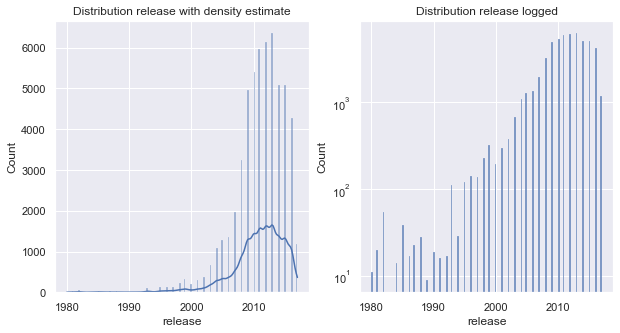

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(x=y2, kde=True, ax=axs[0])
ax1.set(title="Distribution release with density estimate")

ax2 = sns.histplot(x=y2, log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution release logged")

fig;

In [15]:
# Gives several warnings
y2 = stats.boxcox(y2)[0]

/Users/juliet/Documents/UGENT/2021-2022/big_data/practicals/venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:913: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/Users/juliet/Documents/UGENT/2021-2022/big_data/practicals/venv/lib/python3.8/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/juliet/Documents/UGENT/2021-2022/big_data/practicals/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/juliet/Documents/UGENT/2021-2022/big_data/practicals/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/juliet/Documents/UGENT/2021-2022/big_data/practicals/venv/lib/python3.8/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in 

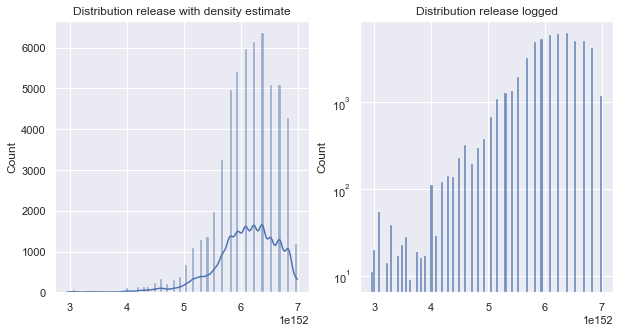

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(data=y2, kde=True, ax=axs[0])
ax1.set(title="Distribution release with density estimate")

ax2 = sns.histplot(data=y2, log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution release logged")

fig;

In [17]:
np.savetxt('featsets/m2/y.csv', y2, delimiter=",")

#### Feature transformation

In [18]:
X2 = df_m2.drop(columns=['release'])
X2 = RobustScaler().fit_transform(X2)

np.savetxt('featsets/m2/X.csv', X2, delimiter=",")